In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ntscraper import Nitter
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud

In [2]:
# Initialize the scraper
scraper = Nitter()

# Function to get tweets
def get_tweets(query, mode, size):
    tweets = scraper.get_tweets(query, mode=mode, number=size)
    final_tweets = []
    for tweet in tweets['tweets']:
        data = [tweet['link'], tweet['text'], tweet['date'], tweet['stats']['likes'], tweet['stats']['comments']]
        final_tweets.append(data)
    return pd.DataFrame(final_tweets, columns=['link', 'text', 'date', 'Likes', 'Comments'])


Testing instances: 100%|██████████| 16/16 [00:36<00:00,  2.27s/it]


In [4]:
# Define the search for tweets (Term: Apple, type: Hashtag and quantity: 200 tweets)
data = get_tweets("Apple", "hashtag", 200)

04-Sep-24 10:24:35 - No instance specified, using random instance https://nitter.lucabased.xyz
04-Sep-24 10:24:42 - Current stats for Apple: 14 tweets, 0 threads...
04-Sep-24 10:24:47 - Current stats for Apple: 24 tweets, 0 threads...
04-Sep-24 10:24:51 - Current stats for Apple: 34 tweets, 0 threads...
04-Sep-24 10:24:56 - Current stats for Apple: 47 tweets, 0 threads...
04-Sep-24 10:25:01 - Current stats for Apple: 56 tweets, 0 threads...
04-Sep-24 10:25:07 - Current stats for Apple: 66 tweets, 0 threads...
04-Sep-24 10:25:12 - Current stats for Apple: 75 tweets, 0 threads...
04-Sep-24 10:25:17 - Current stats for Apple: 80 tweets, 0 threads...
04-Sep-24 10:25:24 - Current stats for Apple: 88 tweets, 0 threads...
04-Sep-24 10:25:29 - Current stats for Apple: 98 tweets, 0 threads...
04-Sep-24 10:25:34 - Current stats for Apple: 103 tweets, 0 threads...
04-Sep-24 10:25:39 - Current stats for Apple: 114 tweets, 0 threads...
04-Sep-24 10:25:44 - Current stats for Apple: 124 tweets, 0 thr

In [7]:
# Sentiment Analysis with VADER
nltk.download('vader_lexicon')
analyzer = SentimentIntensityAnalyzer()

def analyze_sentiment_vader(text):
    sentiment = analyzer.polarity_scores(text)
    if sentiment['compound'] >= 0.05:
        return 'Positive'
    elif sentiment['compound'] <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

data['Sentiment'] = [analyze_sentiment_vader(text) for text in data['text']]

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\MiPC\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [8]:
# Convert dtype of Date column to datetime64
date_format = '%b %d, %Y · %I:%M %p UTC'
data['date'] = pd.to_datetime(data['date'], format=date_format)

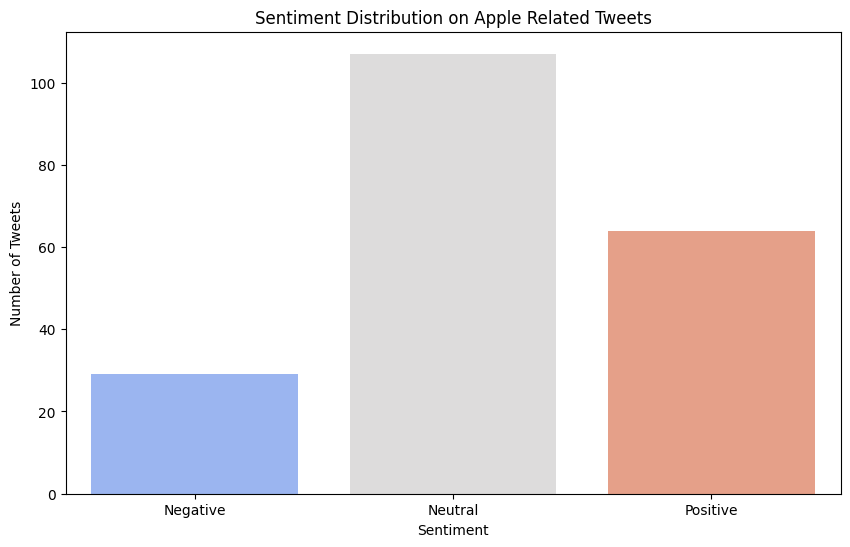

In [34]:
# Sentiment distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Sentiment', data=data, palette='coolwarm', hue='Sentiment')
plt.title('Sentiment Distribution on Apple Related Tweets')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.show()

In [11]:
# LDA Model
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(data['text'])
lda = LatentDirichletAllocation(n_components=5, random_state=0)
lda.fit(X)

# Show Topics
for index, topic in enumerate(lda.components_):
    print(f'Topic {index + 1}:')
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])

Topic 1:
['descubre', 'accesorios', 'watch', 'iphone16', 'que', 'ipad', '16', 'https', 'iphone', 'apple']
Topic 2:
['android', 'news', 'ios', 'pro', 'www', 'amazon', 'com', 'iphone', 'https', 'apple']
Topic 3:
['aiartcommuity', 'models', 'elon', 'com', 'pro', 'new', 'iphone', 'https', 'aiart', 'apple']
Topic 4:
['tech', 'price', 'sbc', 'spotify', 'com', 'vs', 'bitcoin', 'https', 'iphone', 'apple']
Topic 5:
['max', 'new', 'ios', '15', 'www', 'com', 'pro', 'https', 'iphone', 'apple']


In [15]:
# Filter unnecessary words
irrelevant_words = {'descubre', 'accesorios', 'que', 'aiartcommuity', 'aiart', 'elon', 'sbc', 'com', 'https', 'www', 'piped', 'en', 'si', 'ha'}
filtered_topics = []
for topic in lda.components_:
    terms = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]]
    filtered_terms = [term for term in terms if term not in irrelevant_words]
    filtered_topics.append(filtered_terms)

for index, terms in enumerate(filtered_topics):
    print(f'Topic {index + 1}: {terms}')

Topic 1: ['watch', 'iphone16', 'ipad', '16', 'iphone', 'apple']
Topic 2: ['android', 'news', 'ios', 'pro', 'amazon', 'iphone', 'apple']
Topic 3: ['models', 'pro', 'new', 'iphone', 'apple']
Topic 4: ['tech', 'price', 'spotify', 'vs', 'bitcoin', 'iphone', 'apple']
Topic 5: ['max', 'new', 'ios', '15', 'pro', 'iphone', 'apple']


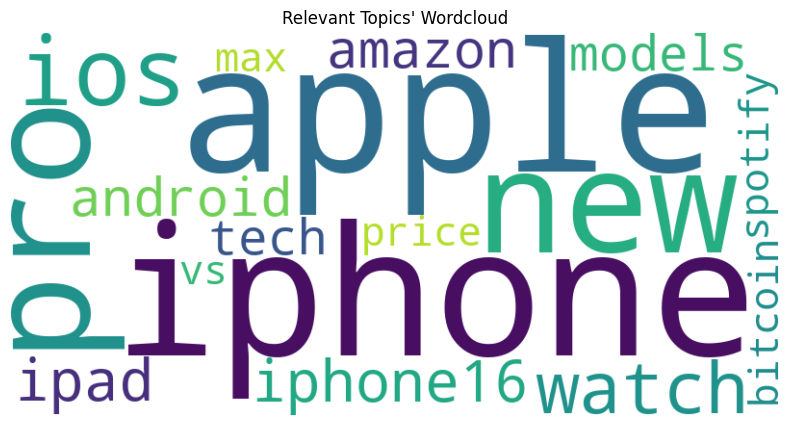

In [17]:
# Wordcloud
all_words = ' '.join([' '.join(terms) for terms in filtered_topics])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Relevant Topics\' Wordcloud')
plt.show()

In [18]:
# Sentiment Analysis with TextBlob
from textblob import TextBlob

def analyze_sentiment_textblob(text):
    analysis = TextBlob(text)
    return pd.Series([analysis.sentiment.polarity, analysis.sentiment.subjectivity], index=['polarity', 'subjectivity'])

data[['polarity', 'subjectivity']] = data['text'].apply(analyze_sentiment_textblob)

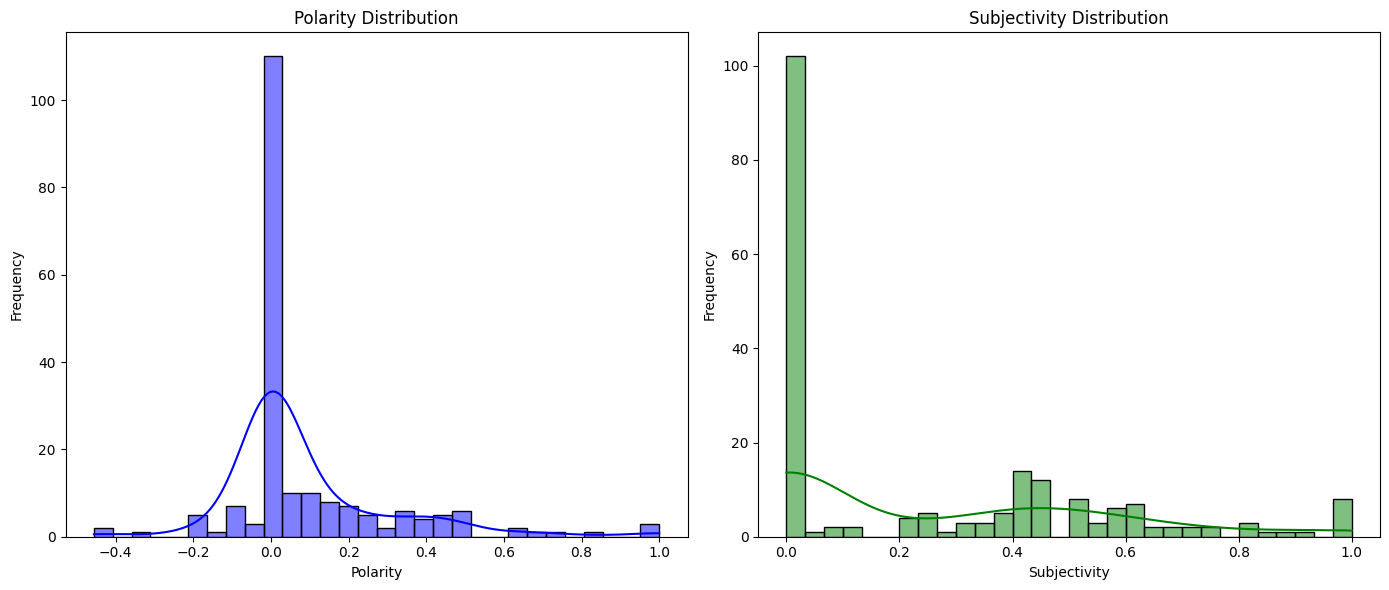

In [20]:
# Polarity and subjectivity distribution
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(data['polarity'], bins=30, kde=True, color='blue')
plt.title('Polarity Distribution')
plt.xlabel('Polarity')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(data['subjectivity'], bins=30, kde=True, color='green')
plt.title('Subjectivity Distribution')
plt.xlabel('Subjectivity')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

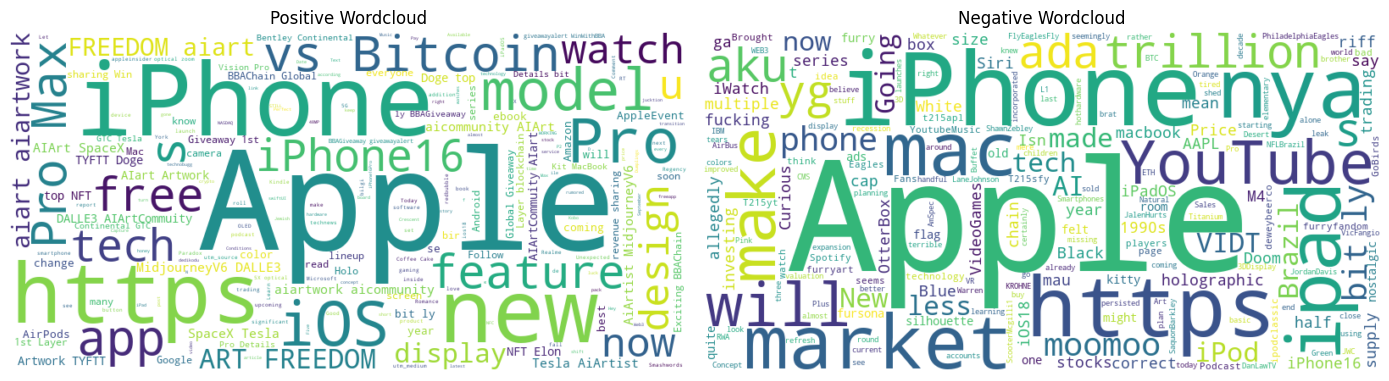

In [22]:
# Wordclouds by polarity
positive_texts = ' '.join(data[data['polarity'] > 0]['text'])
negative_texts = ' '.join(data[data['polarity'] < 0]['text'])

wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_texts)
wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(negative_texts)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Wordcloud')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Wordcloud')

plt.tight_layout()
plt.show()

In [28]:
# Correlation Matrix
correlation_matrix = data[['polarity', 'subjectivity', 'Likes', 'Comments']].corr()

print(correlation_matrix)

              polarity  subjectivity     Likes  Comments
polarity      1.000000      0.439125  0.079242  0.339889
subjectivity  0.439125      1.000000  0.079534  0.131303
Likes         0.079242      0.079534  1.000000  0.352919
Comments      0.339889      0.131303  0.352919  1.000000


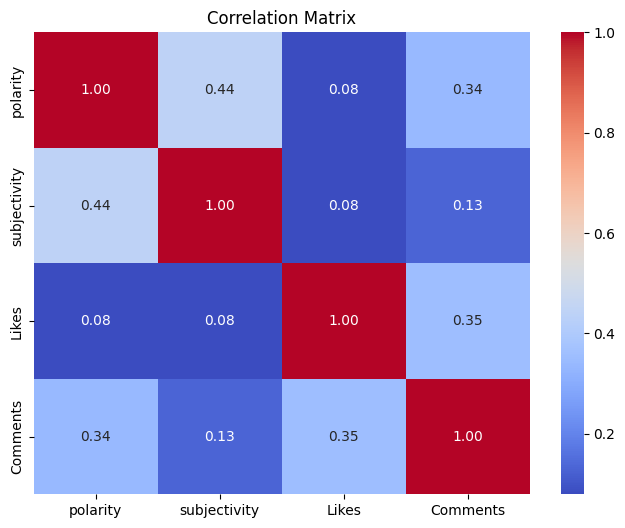

In [29]:
# Plotting CM
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

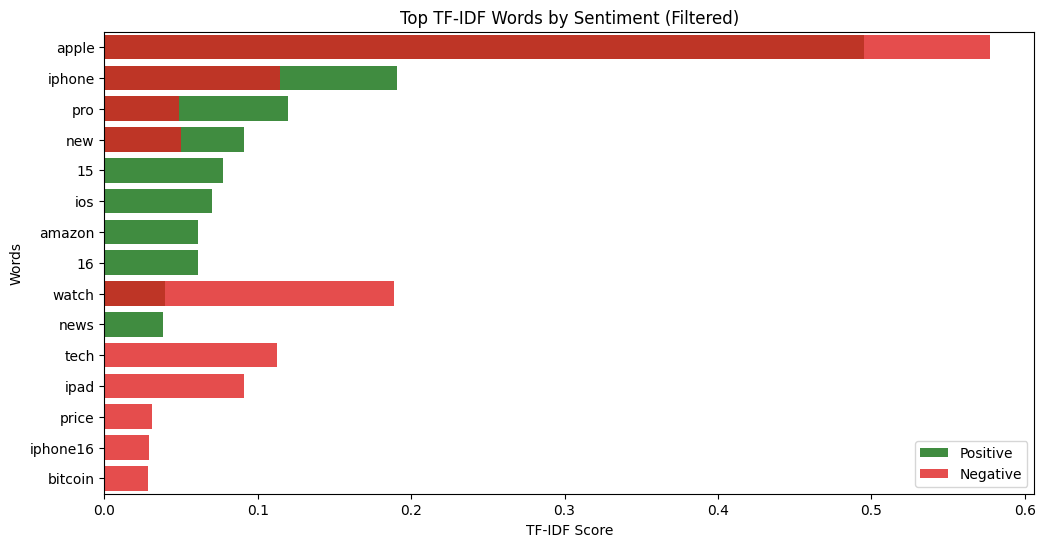

In [41]:
# TF-IDF Analysis with Filtered Topics
tfidf_vectorizer = TfidfVectorizer(stop_words='english', vocabulary=unique_filtered_topics)
X_tfidf = tfidf_vectorizer.fit_transform(data['text'])

# Function to get TF-IDF highest scored for specific sentiments
def get_top_tfidf_words(df, sentiment, top_n=10):
    sentiment_data = df[df['Sentiment'] == sentiment]
    X_sentiment_tfidf = tfidf_vectorizer.transform(sentiment_data['text'])
    tfidf_scores = np.asarray(X_sentiment_tfidf.mean(axis=0)).flatten()
    feature_names = tfidf_vectorizer.get_feature_names_out()
    top_words_idx = tfidf_scores.argsort()[-top_n:][::-1]
    top_words = [feature_names[i] for i in top_words_idx]
    top_scores = [tfidf_scores[i] for i in top_words_idx]
    return pd.DataFrame({'word': top_words, 'tfidf': top_scores})

pos_tfidf_df = get_top_tfidf_words(data, 'Positive')
neg_tfidf_df = get_top_tfidf_words(data, 'Negative')

plt.figure(figsize=(12, 6))
sns.barplot(x='tfidf', y='word', data=pos_tfidf_df, color='green', label='Positive', alpha=0.8)
sns.barplot(x='tfidf', y='word', data=neg_tfidf_df, color='red', label='Negative', alpha=0.8)
plt.title('Top TF-IDF Words by Sentiment (Filtered)')
plt.xlabel('TF-IDF Score')
plt.ylabel('Words')
plt.legend()
plt.show()

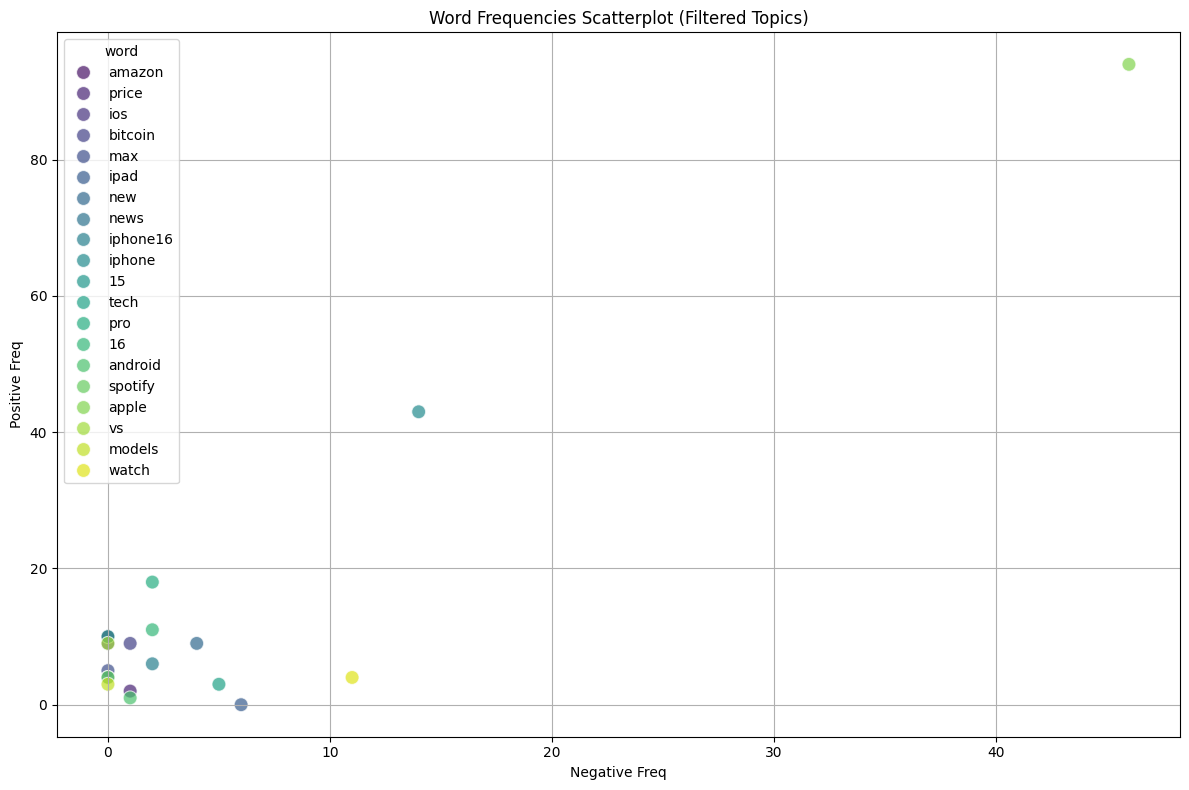

In [42]:
# Create Scatterplot using the word frequencies from filtered topics
plt.figure(figsize=(12, 8))
sns.scatterplot(x=freqs_df['count_neg'], y=freqs_df['count_pos'], hue=freqs_df['word'],
                palette='viridis', s=100, alpha=0.7)
plt.title('Word Frequencies Scatterplot (Filtered Topics)')
plt.xlabel('Negative Freq')
plt.ylabel('Positive Freq')
plt.grid(True)
plt.tight_layout()
plt.show()
